In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

from utils.common import *

# Load Data

In [3]:
ohlc = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\dataCleaned\\poloniex\\5min\\USDT_BTC_5min_2016-01-01_2017-12-31.tsv', sep='\t')\
    .query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)

In [4]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc['timestamp'] = usdtBtc.date.apply(strTimeToTimestamp).astype(int)

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)
ohlcTrain = ohlc.iloc[:trainSize]
ohlcTest = ohlc.iloc[trainSize:]

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain[['close']])
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest[['close']])
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

# Explore

In [ ]:
%matplotlib notebook

In [ ]:
usdtBtcR.columns

In [ ]:
p1 = 13495.7827
p2 = 14270
amount = 100
fee = 0.0025

bought = (p1 * amount) * (1 - fee)


In [ ]:
usdtBtcR.iloc[190:, :]

In [ ]:
step = 361
day = 288
i = day * step
j = i + day
usdtBtcR = usdtBtc.iloc[i:j, :]

paper_rc = {'lines.linewidth': 0.5, 'lines.markersize': 1}                  
sns.set_context("paper", rc = paper_rc) 

fig, ax = plotCandles(ohlc.iloc[i:j, :])
ax2 = ax.twinx()
sns.pointplot(usdtBtcR.timestamp.values, usdtBtcR['vol36'].values, ax=ax2)
sns.pointplot(usdtBtcR.timestamp.values, usdtBtcR['zscore_36_return'].values, ax=ax2, color='green')

set_date_axis(usdtBtcR['timestamp'], ax, fig)

# Implementation

In [32]:
from copy import deepcopy

class CustomStrategy:
    def __init__(self, exchange, dataManager, historyLen, contractPair, tradeSize, willingLoss, 
                 distanceFromMaxThreshold1, distanceFromMaxThreshold2, targetProfit):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.historyLen = historyLen
        self.contractPair = contractPair
        self.opened = False
        self.tradeSize = tradeSize
        self.willingLoss = willingLoss
        self.distanceFromMaxThreshold1 = distanceFromMaxThreshold1
        self.distanceFromMaxThreshold2 = distanceFromMaxThreshold2
        self.targetProfit = targetProfit
    
    
    def isRisky(self, priceBought, actualPrice):
        return self.currentReturn(priceBought, actualPrice) < -self.willingLoss 
    
    
    def currentReturn(self, priceBought, actualPrice):
        feePart = (1 - self.exchange.fee) ** 2
        returnPart = (actualPrice * feePart) / priceBought
        return returnPart - 1
    
    
    def sellWhole(self, price):
        self.opened = False
        amount = self.exchange.balance(self.contractPair['tradeContract'])
        self.exchange.sell(self.contractPair, amount, price)
    
    
    def buy(self, price):
        amount = self.tradeSize / price
        self.exchange.buy(self.contractPair, amount, price)
        self.opened = True
        
        fee = self.exchange.fee
        breakEvenPrice = price / ((1 - fee) ** 2)
#         print('price', price, 'breakEven', breakEvenPrice)
        return breakEvenPrice
        
    
    def isTargetSatisffied(self, priceBought, price):
        return self.currentReturn(priceBought, price) >= self.targetProfit
    
    
    def currentTime(self):
        return self.dataManager.time
    
    def timeExceeded(self, timeBought):
        return (self.currentTime() - timeBought) > self.historyLen
    
    def trade(self):
        
        wasBellow = False
        maxPrice = -1
        while self.dataManager.has_tick():            
            history, price = self.dataManager.tick(self.historyLen)
            if history.shape[0] < self.historyLen:
                continue

            closeMax = history[0].max()
            distanceFromMax = (closeMax / price) - 1
            distanceFromMax2 = (maxPrice / price) - 1
#             print(history.shape[0], distanceFromMax, closeMax, price)
            if not self.opened and not wasBellow and distanceFromMax >= self.distanceFromMaxThreshold1:
                wasBellow = True
                maxPrice = closeMax
            elif not self.opened and wasBellow and distanceFromMax2 <= self.distanceFromMaxThreshold2:
#                 print(self.dataManager.time, 'openning trade: ', price, end='\t')
                breakEvenPrice = self.buy(price)
                priceBought = price
                timeBought = self.currentTime()
            elif self.opened and (self.isRisky(priceBought, price)):
#                 print(self.dataManager.time, 'stopLoss: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)
                wasBellow = False
            elif self.opened and self.isTargetSatisffied(breakEvenPrice, price):
                print(self.dataManager.time, 'profit: ', price, self.currentReturn(breakEvenPrice, price) * 100)
                self.sellWhole(price)
                wasBellow = False
        
        if self.opened:
            self.sellWhole(price)

                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)

# Learning

In [33]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = CustomStrategy(exchange, dataManager, 1*288, contractPair, 100, willingLoss=0.4, 
                                   distanceFromMaxThreshold1=0.04, distanceFromMaxThreshold2=0.03, targetProfit=0.02)
strategy.trade()
strategy.stats('usdt').report()

14695 profit:  1089.68764 2.200791545392522
16720 profit:  1206.99999999 2.222000607335195
19757 profit:  1283.9 2.0971137394701023
20349 profit:  1205.0 2.1879091716053622
30834 profit:  1247.888 2.0194746211320336
34543 profit:  1438.99999988 2.047901175760014
35763 profit:  1635.41150036 2.13703877109761
36578 profit:  1652.53807967 2.1907911200630847
39255 profit:  1867.29251216 2.2273995476127517
41710 profit:  2379.94999999 2.4451999765735533
41742 profit:  2449.99989999 2.259343299727856
41844 profit:  2427.92899993 2.2868342833357813
44664 profit:  2500.0 2.027286985562915
45832 profit:  2822.46500011 2.0206687949495317
57888 profit:  2838.99999999 2.7031275880878614
58252 profit:  2752.11000007 2.091722701255283
61022 profit:  2873.1408594 3.0535434535831074
62036 profit:  2827.99999989 2.0344705995468226
63838 profit:  3439.09110002 2.0112335157593364
65572 profit:  4250.50762793 2.1398466069483257
67991 profit:  4386.0 2.270529350183237


,usdt
startAmount,"1,000.0000"
numberOfTrades,22.0000
totalProfit,45.8146
avgProfit,2.0825
winPercentage,95.4545
avgWinTrade,2.7431
avgLossTrade,-11.7905
profitFactor,4.8857
maxDrawdown,1.1148


In [ ]:
exchange.wallet

In [ ]:
import time, sys
DAY = 288

allStats = None
for historyLen in [DAY, 2*DAY, 3*DAY, 5*DAY]:
    for willingLoss in [.01, .03, .05, .1, .2, .5]:
        for distanceFromMaxThreshold1 in [.01, .02, .05, .07, .1, .2]:
            for distanceFromMaxThreshold2 in [.01, .02, .05, .07, .1, .2]:
                for targetProfit in [.01, .02, .05, .07, .1, .2, .3]:
                    print('historyLen:', historyLen, end='\t')
                    print('willingLoss', willingLoss, end='\t')
                    print('distanceFromMaxThreshold', distanceFromMaxThreshold, end='\t')
                    print('targetProfit', targetProfit, end='\t')
                    sys.stdout.flush()

                    start_time = time.time()
                    dataManager = deepcopy(usdtBtcManagerTrain)
                    exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
                    strategy = DistanceFromMaxStrategy(exchange, dataManager, historyLen, contractPair, 100, willingLoss=willingLoss, 
                                       distanceFromMaxThreshold=distanceFromMaxThreshold, targetProfit=targetProfit)
                    strategy.trade()
                    stats = strategy.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
                    stats['historyLen'] = historyLen
                    stats['willingLoss'] = willingLoss
                    stats['distanceFromMaxThreshold'] = distanceFromMaxThreshold
                    stats['targetProfit'] = targetProfit
                    if allStats is None:
                        allStats = stats
                    else:
                        allStats = allStats.append(stats)
                    print("%.2f seconds" % (time.time() - start_time))

allStats.to_csv('D:\\Dropbox\\My work\\krypl-project\\result\\customStrategy.tsv', index=False, sep='\t')

# Look on transactions

In [ ]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

import time
import datetime as dt

def timestampToDate(timestamp):
    return dt.datetime.fromtimestamp(int(timestamp))

def strTimeToTimestamp(strTime):
    return dt.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S").timestamp()


def calculateMA(history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})


def plotCandles(df, currencyPair):
    DATA = df[['open', 'high', 'low', 'close', 'volume', 'date', 'timestamp']].copy()
    DATA = DATA.reset_index()
    DATA["dateStr"] = DATA["date"]
    DATA["date"]  = DATA["timestamp"].apply(timestampToDate).apply(mdates.date2num)

    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    candlestick_ohlc(ax, DATA.values, width=.6, colorup='#53c156', colordown='#ff1717')

    ax.xaxis_date()
    
    xDates = DATA['dateStr']
    step = int(xDates.shape[0] / 20) + 1
    xDates[[i for i in range(xDates.shape[0]) if i % step != 0]] = ''
    
    plt.xticks(range(DATA.shape[0]), DATA['dateStr'], rotation=45)
    plt.title(currencyPair, fontproperties=titleFont)
    

def plotTransaction(transaction, i):
    print(transaction)
    color = 'k' if transaction['type'] == Transaction.BUY else 'm'
    print(color)
    plt.scatter(i, transaction['price'], s=200, c=color)
    

def plotMax(mmax, i):
    plt.scatter(i, mmax, s=200, c='b')

    
def indexRange(i, offsetBack, offsetForward, length):
    start = i - offsetBack if i - offsetBack > 0 else 0
    end = i + offsetForward if i + offsetForward < length else length-1
    return start, end
    
def plotTransactionWithSurroundings(prices, timePeriod, transaction):
    i = transaction['timestamp']
    start,end = indexRange(i, 40, 20, prices.shape[0])
    selected = prices.iloc[start:end, :].reset_index()
    
    plotCandles(selected, '')
    plotTransaction(transaction, 39)
    
    mmax = prices.iloc[start:i, :]['close'].max()
#     plotMax(mmax, 39)
    

In [24]:
len(strategy.exchange.transactions)

61

In [21]:
def plotTransactions(ohlc, transactions):
    ohlcMaxI = ohlc.shape[0]
    buys = transactionsToPlot(transactions, Transaction.BUY)
    sells = transactionsToPlot(transactions, Transaction.SELL)
    
    firstTransaction = int(min(min(buys[:, 0]), min(sells[:, 0])))
    firstTransaction = firstTransaction - 40 if firstTransaction - 40 > 0 else 0
    
    lastTransaction = int(max(max(buys[:, 0]), max(sells[:, 0])))
    lastTransaction = lastTransaction + 40 if lastTransaction + 40 < ohlcMaxI else ohlcMaxI
    
    fig, ax = plotCandles(ohlc.iloc[firstTransaction:lastTransaction, :])
    
    buyScatter = plt.scatter(buys[:, 0] - firstTransaction, buys[:, 1], s=200, c='g', label='buy')
    sellScatter = plt.scatter(sells[:, 0] - firstTransaction, sells[:, 1], s=200, c='m', label='sell')

    plt.legend(handles=[buyScatter, sellScatter], loc='upper left')

<IPython.core.display.Javascript object>


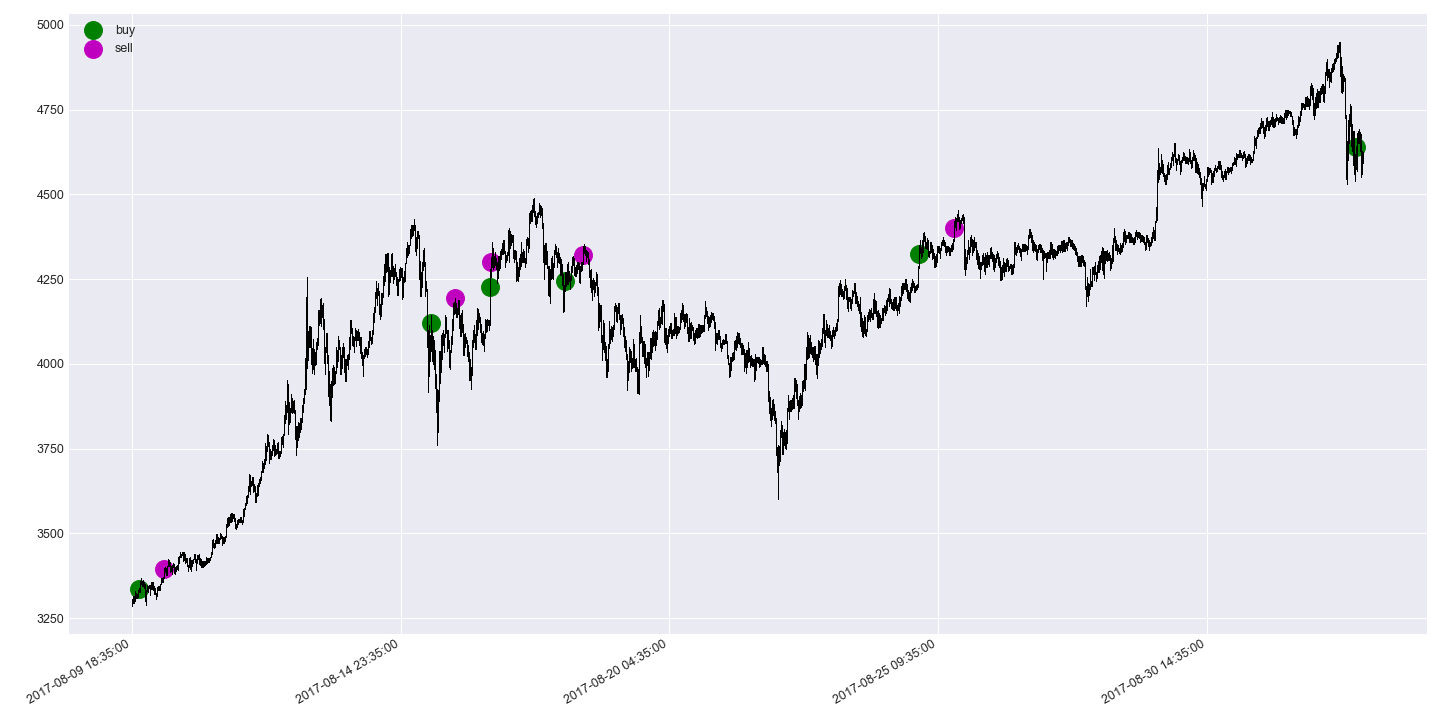

In [26]:
%matplotlib notebook
plotTransactions(ohlcTrain, strategy.exchange.transactions[50:])

In [ ]:
t = 70

transaction = strategy.exchange.transactions[t]
plotTransactionWithSurroundings(ohlcTrain, strategy.historyLen, transaction)
transaction = strategy.exchange.transactions[t+1]
plotTransactionWithSurroundings(ohlcTrain, strategy.historyLen, transaction)

In [ ]:
transaction

# Evaluate Distance From Max

In [ ]:
allStats = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\result\\distanceFromMaxWithTimeRestriction.tsv',sep='\t')

In [ ]:
allStats.query('totalProfit > 90 and winPercentage > 70').sort_values('numberOfTrades', ascending=False)

In [ ]:
dataManager = deepcopy(usdtBtcManagerTest)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = BollingerBandsStrategy(exchange, dataManager, 30, contractPair, 100, willingLoss=0.03, distFromMiddleThreshold=0.02, diffThreshold=0.01)
strategy.trade()
strategy.stats('usdt').report()